# This is a tutorial notebook for the `auto_oo` package

## Installation
First, create an anaconda or pip environment and install PyTorch, for example locally in a cpu-only installation:

```conda install pytorch cpuonly -c pytorch```

Optionally use GPU if your system supports it, but it is not recommended for small active spaces.

For now, it is only interfaced with PySCF to retrieve molecular structure info. This can be changed in the
future to our qc2nl datastructure. To install PySCF, run:

```pip install pyscf```

The updated version of Pennylane is needed if you want to use np_fabrics ansatz, as it needed a bug-fix. Install it by cloning the pennylane repo and installing with `pip install -e .`.

After that, install the `auto_oo` package in the same way: clone the repo, then use `pip install -e .` in the cloned directory. For now, it has some additional dependencies like cirq and openfermion.


## Code structure

```
auto_oo
├── ansatz
│   ├── pqc.py - Here we generate parameterized quantum circuits. There is a method to extract states
│   │            and 1- and 2-Reduced Density Matrices (RDMs)
│   ├── kUpCCD.py -│ Different Ansätze that are modified from Pennylane to exclude single excitations,
│   └── uccd.py   -│ as we can deal with them in the classical orbital-optimization.
├── moldata_pyscf
│   └── moldata_pyscf.py - Interface to pyscf for extracting integrals and overlap matrices
│                          (and optionally do Hartree-Fock or CASSCF to compare results)
├── newton_raphson
│   └── newton_raphson.py - Performs single Newton-Raphson steps (optionally with regularization)
├── oo_energy
│   ├── integrals.py - Functions for computing active space integrals
│   └── oo_energy.py - Here the main code lives. This class is used to calculate auto-differentiable
│                      energies from 1- and 2-RDMs. It can compute analytical gradients and Hessians
│                      with respect to orbital rotations. It has a method to perform orbital optimization
│                      using the newton_raphson module. It is agnostic to the method used to retrieve RDMs.
└── oo_pqc
    ├── oo_pqc.py - A child of the OO_energy class. Here the Parameterized circuit and the oo_energy
    │               come together and with this the user is able to extract orbital and quantum
    │               circuit parameter gradients and (composite) Hessians. It has a method to perform
    │               full (circuit and orbital) optimization with Newton-Raphson steps.
    └── noisy_oo_pqc.py - Adaptation of the above class to include noisy gradients and Hessians used
                          in our sampling noise simulations.
```



In [2]:
import auto_oo
import pennylane as qml
import numpy as np
import torch
import openfermion
import cirq
import matplotlib.pyplot as plt

## Making a parameterized quantum circuit

First define the active space size and the pennylane device. For more information how pennylane handles quantum circuits, see https://pennylane.ai/qml/demos/tutorial_qubit_rotation.html

In [3]:
ncas = 3
nelecas = 4
dev = qml.device('default.qubit', wires=2*ncas)

The `auto_oo.Parameterized_circuit` class has multiple native Ansatzes, like UCC(S)D and Number-preserving Fabrics. One can also input a custom `pennylane.QNode` that outputs a quantum state. Both the parameter vector and output state are `torch.Tensor` objects, that are compatible with automatic differentation in pytorch.

In [4]:
# auto_oo.Parameterized_circuit?

In [5]:
ansatz = 'np_fabric'
n_layers = 2

In [6]:
pqc = auto_oo.Parameterized_circuit(ncas, nelecas, dev, ansatz=ansatz, n_layers=n_layers)

In [7]:
# Print the circuit for a random theta vector.
theta_test = torch.Tensor([np.random.random() for x in range(pqc.theta_shape)])
print(pqc.draw_circuit(theta_test))

0: ──X─╭G²(0.00)─╭OrbitalRotation(0.00)──────────────────────────────────╭G²(0.28)
1: ──X─├G²(0.00)─├OrbitalRotation(0.00)──────────────────────────────────├G²(0.28)
2: ──X─├G²(0.00)─├OrbitalRotation(0.00)─╭G²(0.06)─╭OrbitalRotation(0.14)─├G²(0.28)
3: ──X─╰G²(0.00)─╰OrbitalRotation(0.00)─├G²(0.06)─├OrbitalRotation(0.14)─╰G²(0.28)
4: ─────────────────────────────────────├G²(0.06)─├OrbitalRotation(0.14)──────────
5: ─────────────────────────────────────╰G²(0.06)─╰OrbitalRotation(0.14)──────────

──╭OrbitalRotation(0.11)──────────────────────────────────┤  State
──├OrbitalRotation(0.11)──────────────────────────────────┤  State
──├OrbitalRotation(0.11)─╭G²(0.63)─╭OrbitalRotation(0.53)─┤  State
──╰OrbitalRotation(0.11)─├G²(0.63)─├OrbitalRotation(0.53)─┤  State
─────────────────────────├G²(0.63)─├OrbitalRotation(0.53)─┤  State
─────────────────────────╰G²(0.63)─╰OrbitalRotation(0.53)─┤  State


To extract the state from the pqc class, call the attribute `qnode` that returns a `torch.Tensor`.

In [8]:
state = pqc.qnode(theta_test)
# We can visualize the state in dirac notation with the help of cirq. For this, convert it to a numpy array first:
print(cirq.dirac_notation(state.detach().numpy(), decimals=4))

0.0035|001111⟩ - 0.0005|011011⟩ + 0.0043|011110⟩ + 0.0005|100111⟩ - 0.0043|101101⟩ - 0.2099|110011⟩ + 0.3846|110110⟩ - 0.3846|111001⟩ + 0.8124|111100⟩


From this state, we can extract the spin-restricted 1- and 2-RDMS, defined by:

$$
\begin{align}
    \gamma_{pq}(\boldsymbol{\theta}) &= \langle\psi(\boldsymbol{\theta})|E_{pq}|\psi(\boldsymbol{\theta})\rangle\\
    \Gamma_{pqrs}(\boldsymbol{\theta}) &= \langle\psi(\boldsymbol{\theta})|e_{pqrs}|\psi(\boldsymbol{\theta})\rangle
\end{align}
$$

where $E_{pq} = \sum_\sigma a_{p\sigma}^\dagger a_{q\sigma}$ and $e_{pqrs} = \sum_{\sigma \tau} a_{p\sigma}^\dagger a_{r\tau}^\dagger a_{s\tau} a_{q\sigma} = E_{pq}E_{rs} - \delta_{qr}E_{ps}$.

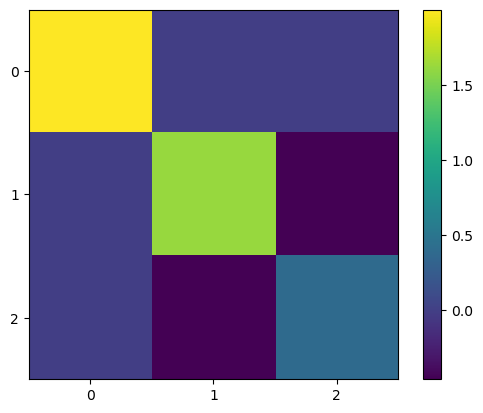

In [9]:
import warnings
warnings.simplefilter("ignore", UserWarning)

one_rdm, two_rdm = pqc.get_rdms_from_state(state)

plt.imshow(one_rdm)
plt.yticks(list(range(ncas)))
plt.xticks(list(range(ncas)))
plt.colorbar()
plt.show()

## Make a cost-function with a molecular Hamiltonian

### PySCF interface

Lets use formaldimine as an example. The `auto_oo` package is interfaced with PySCF to extract molecular properties using `auto_oo.Moldata_pyscf`. ![picture](formaldimine.png)

In [10]:
def get_formal_geo(alpha, phi):
    variables = [1.498047, 1.066797, 0.987109, 118.359375] + [alpha, phi]
    geom = """
                    N
                    C 1 {0}
                    H 2 {1}  1 {3}
                    H 2 {1}  1 {3} 3 180
                    H 1 {2}  2 {4} 3 {5}
                    """.format(*variables)
    return geom

In [11]:
alpha = 140
phi = 80
basis = 'sto-3g'
mol = auto_oo.Moldata_pyscf(get_formal_geo(alpha,phi), basis)

(13, 13)
(13, 13, 13, 13)


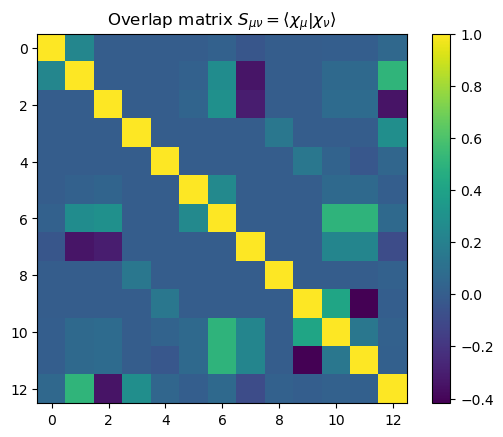

In [12]:
# This class stores the integrals and the overlap matrix for example:
print(mol.int1e_ao.shape)
print(mol.int2e_ao.shape)
plt.title(r'Overlap matrix $S_{\mu \nu} = \langle \chi_\mu | \chi_\nu \rangle$')
plt.imshow(mol.overlap)
plt.colorbar()
plt.show()

We can also run Hartree-Fock, CASCI or CASSCF:

In [13]:
mol.run_rhf()
mol.run_casci(ncas, nelecas)
mol.run_casscf(ncas, nelecas)

In [14]:
print(f'Hartree-Fock energy: {mol.hf.e_tot:.6f}')
print(f'CASCI energy:        {mol.casci.e_tot:.6f}')
print(f'CASSCF energy:       {mol.casscf.e_tot:.6f}')

Hartree-Fock energy: -92.663722
CASCI energy:        -92.736706
CASSCF energy:       -92.749954


### Orbital Optimized energies and Hamiltonians

To extract Hamiltonian and energies in different MO basis, feed it into the `OO_energy` class. If you the user does not input any MO coefficients, it defaults to Hartree-Fock MOs.

In [15]:
oo_energy = auto_oo.OO_energy(mol, ncas, nelecas)

In [16]:
# Test if the MOs are indeed HF:
np.allclose(oo_energy.mo_coeff.detach().numpy(), mol.hf.mo_coeff)

True

We can compute the active space energy with the RDMs from the `pqc` class. In an active space, the total energy is given by:
$$
    E = E_{\rm nuc} + E_{\rm core} +
    \sum_{pq}\tilde{h}_{pq} \gamma_{pq} +
    \sum_{pqrs} g_{pqrs} \Gamma_{pqrs}
$$
where $E_{core}$ is the mean-field energy of the core (doubly-occupied) orbitals,
$\tilde{h}_{pq}$ is contains the active one-body terms plus the mean-field
interaction of core-active orbitals and $g_{pqrs}$ are the active integrals
in chemist ordering.

In [17]:
energy_random_theta = oo_energy.energy_from_mo_coeff(oo_energy.mo_coeff, one_rdm, two_rdm).item()

In [18]:
print(f'Energy with a random theta: {energy_random_theta:.6f}')

Energy with a random theta: -92.658779


Of course, the energy with a random theta is not great. While the `auto_oo` package is really only meant to give you primitives of energies and parameter derivatives, there is a method included to optimize the orbitals, that uses the `newton_raphson` module. We can optimize the orbitals for this specific state by calling the `orbital_optimization` method.

In [19]:
# For information on the Newton-Rapshon optimization procedure:
auto_oo.NewtonStep?

In [20]:
energy_l = oo_energy.orbital_optimization(one_rdm, two_rdm)

iter = 000, energy = -92.724594626699
iter = 001, energy = -92.727356886588
iter = 002, energy = -92.733541457253
iter = 003, energy = -92.734397910202
iter = 004, energy = -92.745265941052
iter = 005, energy = -92.746107791465
iter = 006, energy = -92.746329217327
iter = 007, energy = -92.746389774085
iter = 008, energy = -92.746586227954
iter = 009, energy = -92.746699183594
iter = 010, energy = -92.746734254701
iter = 011, energy = -92.746736783644
iter = 012, energy = -92.746771675358
iter = 013, energy = -92.746803002409
iter = 014, energy = -92.746816273829
iter = 015, energy = -92.746817152217
iter = 016, energy = -92.746817160199


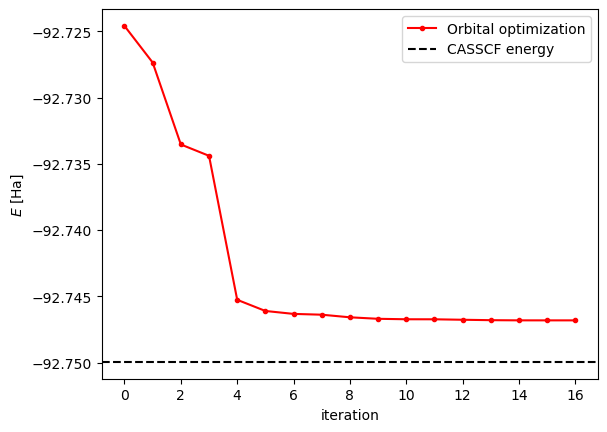

In [21]:
plt.plot(energy_l, '.-r', label='Orbital optimization')
plt.axhline(mol.casscf.e_tot, ls='--', c='k', label='CASSCF energy')
plt.xlabel('iteration')
plt.ylabel(r'$E$ [Ha]')
plt.legend()
plt.show()

## Optimizing a circuit 
While this gives us optimized orbitals for a random theta, a user usually often interested in optimizing he parameters as well. Lets do it for the Hartree-Fock orbitals. As this is not functionality that is inside `auto_oo`, we can import from PyTorch a gradient descent optimizer. 

First, extract the active space Hamiltonian

In [22]:
# We can extract the Hamiltonian as an openfermion FermionOperator for the Hartree-Fock orbitals
c0, c1, c2 = oo_energy.get_active_integrals(torch.from_numpy(mol.hf.mo_coeff))
fermionic_cas_hamiltonian = auto_oo.fermionic_cas_hamiltonian(c0, c1, c2)

In [23]:
# Compute the eigenvalues to make sure we have the correct Hamiltonian
fch_energies = openfermion.eigenspectrum(fermionic_cas_hamiltonian)
e_0 = fch_energies[0]
print(f'Based on HF orbitals, the CASCI ground state energy is: {e_0:.6f}')
print(f'CASCI energy from PySCF:                                {mol.casci.e_tot:.6f}')

Based on HF orbitals, the CASCI ground state energy is: -92.736706
CASCI energy from PySCF:                                -92.736706


Now we can convert it to a pennylane observable to measure with a `qml.qnode`. First convert it to a QubitOperator with the Jordan-Wigner transformation.

In [24]:
qubit_cas_hamiltonian = openfermion.jordan_wigner(fermionic_cas_hamiltonian)

In [25]:
pennylane_cas_hamiltonian = qml.qchem.import_operator(qubit_cas_hamiltonian)

For the ansatz lets choose the same one that is inside the `pqc` class, the GateFabric ansatz. We can optimize it with the Adam optimizer from PyTorch. This automatically computes the gradient at every step. It can do so quickly because of automatic-differentation of the circuit.

In [26]:
@qml.qnode(dev, interface='torch', diff_method='backprop')
def cost_function(theta):
    """ Outputs NP fabric ansatz state"""
    qml.GateFabric(theta,
                   wires=pqc.wires, init_state=pqc.hfstate, include_pi=False)
    return qml.expval(pennylane_cas_hamiltonian)

In [27]:
theta = torch.zeros(pqc.full_theta_shape)
theta.requires_grad = True

energy_init = cost_function(theta).item()
print(f'Zero parameters give us an energy of:       {energy_init:.6f}')
print(f'Should be equal to the Hartree-Fock energy: {mol.hf.e_tot:.6f}')

Zero parameters give us an energy of:       -92.663722
Should be equal to the Hartree-Fock energy: -92.663722


In [28]:
# Define hyperparameters and optimizer of the VQE
max_iterations = 100
conv_tol = 1e-8
stepsize = 0.03
e_min = 1e99
opt = torch.optim.Adam([theta],lr=stepsize)

# Save results in
opt_trajectory = [energy_init]
theta_trajectory = [theta.detach().clone()]

In [29]:
for n in range(max_iterations):
    # At every step, clear the gradient and do a backward pass to compute
    # the gradient. Then perform one step of the Adam optimizer.
    opt.zero_grad()
    loss = cost_function(theta)
    loss.backward()
    opt.step()

    curr_energy = cost_function(theta).item()

    print('iter, e =', n, curr_energy)
    opt_trajectory.append(curr_energy)
    theta_trajectory.append(theta.detach().clone())

    if curr_energy < e_min:
        e_min = curr_energy
        n_min = n
        theta_min = theta.detach().clone()
    
    # Convergence condition
    if n > 1:
        if (np.abs(opt_trajectory[-1] - opt_trajectory[-2])\
            < conv_tol):
            print("\nVQE converged")
            print(f'VQE energy: {opt_trajectory[-1]:.6f}')
            print(f'CASCI energy:  {mol.casci.e_tot:.6f}')
            break


iter, e = 0 -92.66637216451434
iter, e = 1 -92.66870321172412
iter, e = 2 -92.67069563432949
iter, e = 3 -92.67259714066233
iter, e = 4 -92.67433510170285
iter, e = 5 -92.67585618080425
iter, e = 6 -92.67714338218292
iter, e = 7 -92.67827065721663
iter, e = 8 -92.67937801078982
iter, e = 9 -92.68054015697632
iter, e = 10 -92.68177226119694
iter, e = 11 -92.68310095592635
iter, e = 12 -92.68457882027792
iter, e = 13 -92.68625363121765
iter, e = 14 -92.68814198198015
iter, e = 15 -92.69023050784038
iter, e = 16 -92.69249073709351
iter, e = 17 -92.69489092671061
iter, e = 18 -92.69739971446725
iter, e = 19 -92.6999844995213
iter, e = 20 -92.70260924104626
iter, e = 21 -92.70523441757226
iter, e = 22 -92.7078199249602
iter, e = 23 -92.71033009525597
iter, e = 24 -92.71273824128647
iter, e = 25 -92.71502714031308
iter, e = 26 -92.71718420494314
iter, e = 27 -92.71919625758106
iter, e = 28 -92.72105119911326
iter, e = 29 -92.7227454795804
iter, e = 30 -92.72428673872109
iter, e = 31 -92.7256

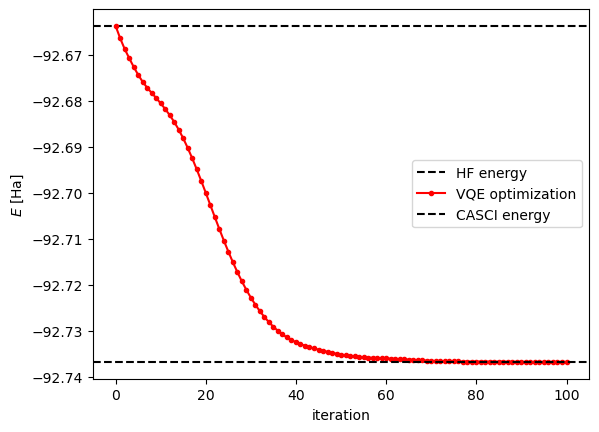

In [30]:
plt.axhline(mol.hf.e_tot, ls='--', c='k', label='HF energy')
plt.plot(opt_trajectory, '.-r', label='VQE optimization')
plt.axhline(mol.casci.e_tot, ls='--', c='k', label='CASCI energy')
plt.xlabel('iteration')
plt.ylabel(r'$E$ [Ha]')
plt.legend()
plt.show()

## Put the parameterized quantum circuit and differentiable cost function together with `OO_pqc_cost`

If you want a cost function dependent on both quantum circuit parameters $\theta$ and orbital rotation parameters $\kappa$, use the `OO_energy` child class `OO_pqc_cost`. With this you can compute gradients to both parameters, and including composite Hessians.

In [31]:
oo_pqc = auto_oo.OO_pqc_cost(pqc, mol, ncas, nelecas, freeze_active=True)

We can now retrieve the full Hessian to all the parameters. It can be written as:

$$
\begin{align}
    \nabla_{(\boldsymbol{\theta},\boldsymbol{\kappa})} E 
    &= (\nabla_{\boldsymbol{\theta}}E, \nabla_{\boldsymbol{\kappa}} E)  \label{eq:composite-gradient}
    \\
    \nabla^2_{(\boldsymbol{\theta},\boldsymbol{\kappa})} E 
    &= 
    \begin{bmatrix}
        \nabla^2_{\boldsymbol{\theta}}E 
        & \nabla_{\boldsymbol{\kappa}}\nabla_{\boldsymbol{\theta}} E\\
        (\nabla_{\boldsymbol{\kappa}}\nabla_{\boldsymbol{\theta}} E)^\intercal
        & \nabla^2_{\boldsymbol{\kappa}} E 
    \end{bmatrix}.  \label{eq:composite-hessian}
\end{align}
$$

The off-diagonal blocks are computed by auto-differentation of the analytical gradient of $\kappa$ w.r.t. $\theta$ 

In [32]:
print("Number of thetas:", pqc.theta_shape)
print("Number of kappas:", oo_pqc.n_kappa)
print("Shape of the full Hessian matrix:", oo_pqc.full_hessian(theta_test).shape)

Number of thetas: 6
Number of kappas: 54
Shape of the full Hessian matrix: torch.Size([60, 60])


To perform full optimization (i.e. OO-VQE) of both circuit and orbital parameters with the Newton-raphson method, we can call the `full_optimizaton` method of `OO_pqc_cost`.

In [33]:
energy_l, theta_l, kappa_l, oao_mo_coeff_l, hess_eig_l = oo_pqc.full_optimization(theta_test)

iter = 000, energy = -92.658778696061
iter = 001, energy = -92.697102947742
iter = 002, energy = -92.736598056738
iter = 003, energy = -92.739332657940
iter = 004, energy = -92.745969251668
iter = 005, energy = -92.747051944781
iter = 006, energy = -92.747851465658
iter = 007, energy = -92.748515639380
iter = 008, energy = -92.748672954681
iter = 009, energy = -92.749170128488
iter = 010, energy = -92.749308589498
iter = 011, energy = -92.749420226660
iter = 012, energy = -92.749515834907
iter = 013, energy = -92.749610434277
iter = 014, energy = -92.749657924704
iter = 015, energy = -92.749714894942
iter = 016, energy = -92.749823575069
iter = 017, energy = -92.749896863403
iter = 018, energy = -92.749937660009
iter = 019, energy = -92.749953661485
iter = 020, energy = -92.749953681386
iter = 021, energy = -92.749953681394
optimization finished.
E_fin = -92.74995368139444


In [34]:
print("\nOO-VQE converged")
print(f'OO-VQE energy: {energy_l[-1]:.6f}')
print(f'CASSCF energy: {mol.casscf.e_tot:.6f}')


OO-VQE converged
OO-VQE energy: -92.749954
CASSCF energy: -92.749954


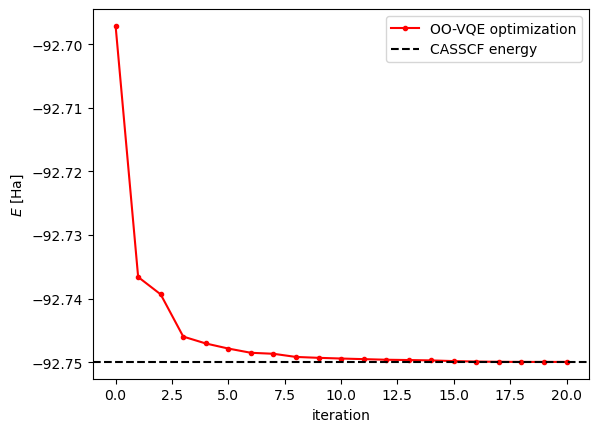

In [35]:
plt.plot(energy_l, '.-r', label='OO-VQE optimization')
plt.axhline(mol.casscf.e_tot, ls='--', c='k', label='CASSCF energy')
plt.xlabel('iteration')
plt.ylabel(r'$E$ [Ha]')
plt.legend()
plt.show()

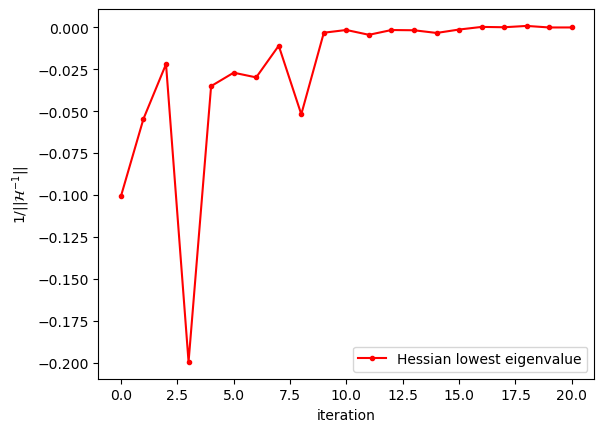

In [36]:
plt.plot(hess_eig_l, '.-r', label='Hessian lowest eigenvalue')
plt.xlabel('iteration')
plt.ylabel(r'$1/||\mathcal{H}^{-1}||$')
plt.legend()
plt.show()

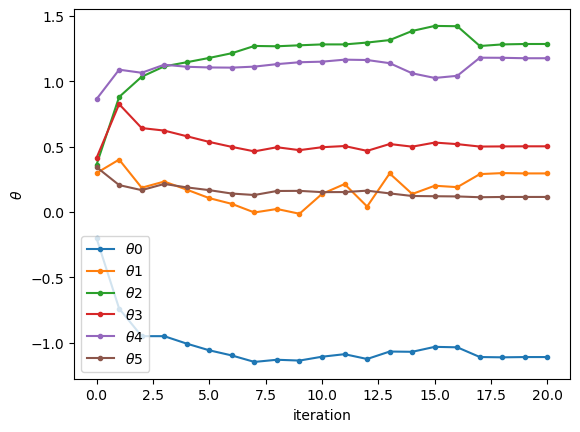

In [37]:
for i in range(len(theta_test)):
    plt.plot([theta_l[j][i] for j in range(len(theta_l))], '.-', label=f'$\\theta {i}$')
plt.xlabel('iteration')
plt.ylabel(r'$\theta$')
plt.legend()
plt.show()

## Continuity-constrained single parameter updates to calculate a berry phase

<img src="./three_loops_FCI.png" alt="Drawing" style="width: 400px;"/>

The `auto_oo` package was made with in mind the ability to start a calculation with converged parameters (both orbitals and quantum circuit) of a _different_ geometry. For example to generate a potential energy surface for a given path in nuclear configuration space where the parameters vary continuously throughout this path. A problem arises here: a set of MO coefficients that represent orthonormal MOs on one geometry does not result in orthonormal MOs of the next geometry as the non-orthogonal AOs change. To mitigate this problem we chose to take as a reference the _Orthonormal Atomic Orbitals_ (OAOs), defined by $C_{\mu p} = S^{-1/2}_{\mu p}$, where $S$ is the overlap matrix. Thus, the MOs are parameterized as:

$$
\phi_p (C, \mathbf{R}) = \sum_{\mu q} \chi_\mu(\mathbf{R}) S^{-1/2}_{\mu q}(\mathbf{R}) C_{q p}
$$

In the `OO_energy` and `OO_pqc_cost` classes, this relevant OAO-MO coefficient matrix $C$ is stored as the attribute `oao_mo_coeff`. One can access the usual AO-MO coefficients as the property `mo_coeff`, which is automatically computed from $C$ when called.

### Defining the loop

To calculate the berry phase, we can define a loop in nuclear configuration space and do continuous single parameter updates throughout the loop. Lets use `auto_oo` for this.

In [38]:
def get_alpha_phi(t, origin, radius, phase):
    alpha = origin[0] + radius[0] * np.cos(2*np.pi*t + phase)
    phi = origin[1] + radius[1] * np.sin(2*np.pi*t + phase)
    return alpha, phi

In [39]:
origin = (130, 89.9)
radius = (10, 10)
t0 = 0.
phase = np.pi/20
n_points = 10

In [40]:
t_l = [t0 + dt for dt in np.linspace(0, 1, n_points)]
alpha_phi_l = [(get_alpha_phi(t, origin, radius, phase)) for t in t_l]
loop_geoms = [get_formal_geo(
    *get_alpha_phi(t, origin, radius, phase)) for t in t_l]

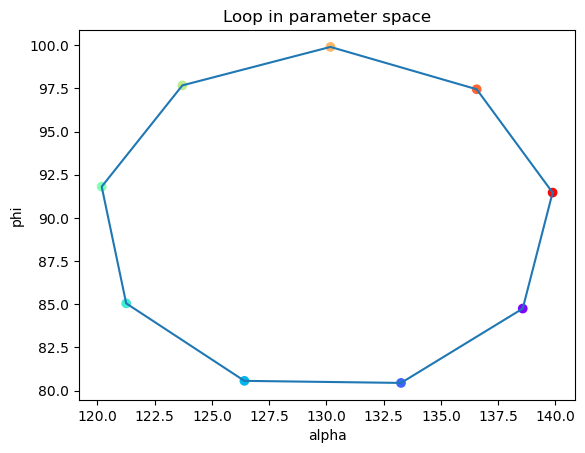

In [41]:
from matplotlib import colormaps
import matplotlib.cm as cm
vir = colormaps['viridis']
n = cm.rainbow(np.flip(np.linspace(0.01, 0.99, n_points-1)))

plt.title("Loop in parameter space")
plt.scatter(*zip(*alpha_phi_l[:-1]), color=n)  # c=n,cmap=vir)

plt.xlabel('alpha')
plt.ylabel('phi')
plt.plot(*zip(*alpha_phi_l))
plt.show()

### Defining the initial point
Perform exact optimization at the first geometry, such that we have a good starting point:

In [42]:
# Lets use a minimal basis and CAS for now
ncas = 2
nelecas = 2
basis = 'sto-3g'
n_layers = 1

In [43]:
dev = qml.device('default.qubit', wires=2*ncas)
pqc = auto_oo.Parameterized_circuit(ncas, nelecas, dev,
                                    ansatz='np_fabric',
                                    n_layers=n_layers)

In [44]:
mol0 = auto_oo.Moldata_pyscf(loop_geoms[0], basis)
mol0.run_rhf()
mol0.run_casscf(ncas, nelecas)

In [45]:
oo_pqc0 = auto_oo.OO_pqc_cost(pqc, mol0, ncas, nelecas, freeze_active=True)

In [46]:
theta0 = pqc.init_zeros()
energy_opt, theta_opt, kappa_opt, oao_mo_coeff_opt, hess_eig_opt = oo_pqc0.full_optimization(theta0)
vhess, _ = torch.linalg.eigh(oo_pqc0.full_hessian(theta_opt[-1]))
final_hess_eig = vhess[0].item()

theta_l = [theta_opt[-1]]
oao_mo_coeff_l = [oao_mo_coeff_opt[-1]]
mol_l = [mol0]
energy_l = [energy_opt[-1]]
casscf_energy_l = [mol0.casscf.e_tot]
print("Pre-opt point lowest Hessian eigenvalue:", final_hess_eig)
hess_eig_l = [final_hess_eig]

curr_theta = theta_opt[-1]
curr_oao_mo_coeff = oao_mo_coeff_opt[-1]

print("OO-VQE energy =", energy_opt[-1])
print("Casscf energy =", mol0.casscf.e_tot)

iter = 000, energy = -92.661535185335
iter = 001, energy = -92.675349726518
iter = 002, energy = -92.719923926585
iter = 003, energy = -92.742979934153
iter = 004, energy = -92.745900351861
iter = 005, energy = -92.746027388401
iter = 006, energy = -92.746027566472
iter = 007, energy = -92.746027566472
optimization finished.
E_fin = -92.74602756647198
Pre-opt point lowest Hessian eigenvalue: 0.029872961249268026
OO-VQE energy = -92.74602756647198
Casscf energy = -92.74602756620031


### Single Newton steps throughout the loop

In [47]:
opt = auto_oo.NewtonStep(verbose=0)

print('\n\n----------STARTING TRAJECTORY---------')
for step, geo in enumerate(loop_geoms):
    if step == 0:
        continue
    mol = auto_oo.Moldata_pyscf(geo, basis)
    mol.run_casscf(ncas, nelecas)

    oo_pqc = auto_oo.OO_pqc_cost(pqc, mol, ncas, nelecas, freeze_active=True)
    oo_pqc.oao_mo_coeff = curr_oao_mo_coeff

    kappa = torch.zeros(oo_pqc.n_kappa)

    gradient = oo_pqc.full_gradient(curr_theta)
    hessian = oo_pqc.full_hessian(curr_theta)

    new_parameters, hess_eig = opt.damped_newton_step(
        oo_pqc.energy_from_parameters, (curr_theta, kappa),
        gradient, hessian)

    curr_theta = new_parameters[0]
    kappa = new_parameters[1]

    curr_oao_mo_coeff = curr_oao_mo_coeff @ oo_pqc.kappa_to_mo_coeff(kappa)
    oo_pqc.oao_mo_coeff = curr_oao_mo_coeff.detach().clone()

    energy = oo_pqc.energy_from_parameters(curr_theta).item()

    theta_l.append(curr_theta.detach().clone())
    oao_mo_coeff_l.append(curr_oao_mo_coeff.detach().clone())
    mol_l.append(mol)
    energy_l.append(energy)
    casscf_energy_l.append(mol.casscf.e_tot)
    hess_eig_l.append(hess_eig)
    
    print(f'Energy at step {step}: {energy}')

print('\n\n----------TRAJECTORY DONE!-----------')



----------STARTING TRAJECTORY---------
Energy at step 1: -92.74733259858228
Energy at step 2: -92.75324253035363
Energy at step 3: -92.75439239892033
Energy at step 4: -92.75794711528604
Energy at step 5: -92.75656855101595
Energy at step 6: -92.7564156722306
Energy at step 7: -92.74998747906973
Energy at step 8: -92.74659635329397
Energy at step 9: -92.74478708031945


----------TRAJECTORY DONE!-----------


### Calculating the states and the final overlap

In [48]:
states_l = []
print("states around loop:")
for step, theta in enumerate(theta_l):
    state = pqc.qnode(theta).detach().numpy()
    states_l.append(state)
    print(f'Step {step:2d}:  ψ =', cirq.dirac_notation(state, decimals=2))

states around loop:
Step  0:  ψ = -0.39|0011⟩ - 0.06|0110⟩ + 0.06|1001⟩ + 0.92|1100⟩
Step  1:  ψ = -0.4|0011⟩ - 0.07|0110⟩ + 0.07|1001⟩ + 0.91|1100⟩
Step  2:  ψ = -0.45|0011⟩ - 0.12|0110⟩ + 0.12|1001⟩ + 0.88|1100⟩
Step  3:  ψ = -0.55|0011⟩ - 0.23|0110⟩ + 0.23|1001⟩ + 0.77|1100⟩
Step  4:  ψ = -0.61|0011⟩ - 0.29|0110⟩ + 0.29|1001⟩ + 0.68|1100⟩
Step  5:  ψ = -0.69|0011⟩ - 0.4|0110⟩ + 0.4|1001⟩ + 0.45|1100⟩
Step  6:  ψ = -0.69|0011⟩ - 0.42|0110⟩ + 0.42|1001⟩ + 0.4|1100⟩
Step  7:  ψ = -0.7|0011⟩ - 0.48|0110⟩ + 0.48|1001⟩ + 0.2|1100⟩
Step  8:  ψ = -0.69|0011⟩ - 0.49|0110⟩ + 0.49|1001⟩ + 0.18|1100⟩
Step  9:  ψ = -0.68|0011⟩ - 0.51|0110⟩ + 0.51|1001⟩ + 0.12|1100⟩


To calculate transform the states from one MO basis to another, we use a bogoliubov transformation in the active space:

$$
G_{0\to1} = 
\exp
\Big\{ 
    \sum_{\{p,q\}\in \text{AS}}
    [\log(C_{0\to1})]_{pq} c^\dagger_p c_q
\Big\},
$$

The final overlap is then calculated as:

$$
\Re\left[\langle 0| U^\dagger(\theta_0) G_{0\to1} U(\theta_1) |0\rangle\right].
$$

In [49]:
def bogoliubov_atob_cas(mo_atob, active_indices):
    '''
    Compute bogliubov transformation of G^dag_a G_b on state level.
    Openfermions convention is summation over second index, so the input is transposed.
    Only takes into account active space rotations.
    WARNING: input is torch.Tensor, output is numpy ndarray!
    '''
    mo_atob_R_as = torch.t(mo_atob)[np.ix_(*[active_indices]*2)]
    mo_atob_U_as = auto_oo.oo_energy.integrals.restricted_to_unrestricted(
        mo_atob_R_as).detach().numpy()
    bogoliubov_atob = cirq.Circuit(
        openfermion.bogoliubov_transform(
            cirq.LineQubit.range(2*len(active_indices)), mo_atob_U_as)).unitary()
    bogoliubov_atob = bogoliubov_atob / bogoliubov_atob[0, 0]
    # use |0000> to set a gauge phase reference for the Bogoliubov unitary
    return bogoliubov_atob


In [50]:
mo_atob_l = []
state_atob_l = []
for point_nr in range(1, n_points):
    mo_atob = oao_mo_coeff_l[point_nr-1].T @ oao_mo_coeff_l[point_nr]
    state_atob = bogoliubov_atob_cas(mo_atob, oo_pqc0.act_idx)
    mo_atob_l.append(mo_atob)
    state_atob_l.append(state_atob)
mo_atob = oao_mo_coeff_l[-1].T @ oao_mo_coeff_l[0]
state_atob = bogoliubov_atob_cas(mo_atob, oo_pqc0.act_idx)
mo_atob_l.append(mo_atob)
state_atob_l.append(state_atob)

In [51]:
states_next_basis = []
for i in range(n_points):
    state = states_l[i]
    state_next_basis = state_atob_l[i] @ state
    states_next_basis.append(state_next_basis)
    print(f'State {i}:', cirq.dirac_notation(state))
    if i == n_points-1:
        print(f'State G {i}->{0}:', cirq.dirac_notation(state_next_basis))
    else:
        print(f'State G {i}->{i+1}:', cirq.dirac_notation(state_next_basis))

State 0: -0.39|0011⟩ - 0.06|0110⟩ + 0.06|1001⟩ + 0.92|1100⟩
State G 0->1: -0.38|0011⟩ - 0.12|0110⟩ + 0.12|1001⟩ + 0.91|1100⟩
State 1: -0.4|0011⟩ - 0.07|0110⟩ + 0.07|1001⟩ + 0.91|1100⟩
State G 1->2: -0.4|0011⟩ - 0.09|0110⟩ + 0.09|1001⟩ + 0.91|1100⟩
State 2: -0.45|0011⟩ - 0.12|0110⟩ + 0.12|1001⟩ + 0.88|1100⟩
State G 2->3: -0.42|0011⟩ - 0.22|0110⟩ + 0.22|1001⟩ + 0.85|1100⟩
State 3: -0.55|0011⟩ - 0.23|0110⟩ + 0.23|1001⟩ + 0.77|1100⟩
State G 3->4: -0.55|0011⟩ - 0.23|0110⟩ + 0.23|1001⟩ + 0.77|1100⟩
State 4: -0.61|0011⟩ - 0.29|0110⟩ + 0.29|1001⟩ + 0.68|1100⟩
State G 4->5: -0.58|0011⟩ - 0.35|0110⟩ + 0.35|1001⟩ + 0.65|1100⟩
State 5: -0.69|0011⟩ - 0.4|0110⟩ + 0.4|1001⟩ + 0.45|1100⟩
State G 5->6: -0.69|0011⟩ - 0.4|0110⟩ + 0.4|1001⟩ + 0.45|1100⟩
State 6: -0.69|0011⟩ - 0.42|0110⟩ + 0.42|1001⟩ + 0.4|1100⟩
State G 6->7: -0.65|0011⟩ - 0.48|0110⟩ + 0.48|1001⟩ + 0.35|1100⟩
State 7: -0.7|0011⟩ - 0.48|0110⟩ + 0.48|1001⟩ + 0.2|1100⟩
State G 7->8: -0.69|0011⟩ - 0.5|0110⟩ + 0.5|1001⟩ + 0.19|1100⟩
State 8: -0

In [52]:
overlaps = [np.conj(states_l[i+1]).T @ states_next_basis[i]
                for i in range(n_points-1)] + [
    np.conj(states_l[0]).T @ states_next_basis[-1]]
print("Overlaps:")
for i, ovlp in enumerate(overlaps):
    print(i,ovlp.real)

Overlaps:
0 0.996616344617272
1 0.9972758937826585
2 0.9890063074452609
3 0.9900918913016968
4 0.9727580979804349
5 0.9981947394737328
6 0.987093632105646
7 0.9999569172720071
8 0.9982147077491825
9 -0.99879933610869


### Plotting results
If everything is correct, you should have got a final overlap close to $\langle \psi_f|\psi_s\rangle \approx -1$, meaning we measured a berry phase $\Pi_\mathcal{C} = \arg \langle \psi_f|\psi_s\rangle = \pi$.

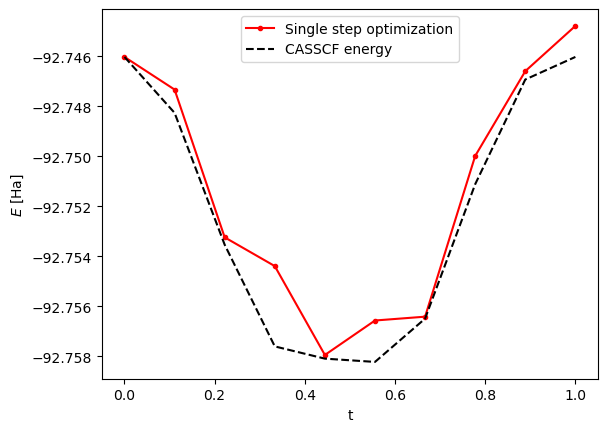

In [53]:
plt.plot(t_l, energy_l, '.-r', label='Single step optimization')
plt.plot(t_l, casscf_energy_l, '--k', label='CASSCF energy')
plt.xlabel('t')
plt.ylabel(r'$E$ [Ha]')
plt.legend()
plt.show()

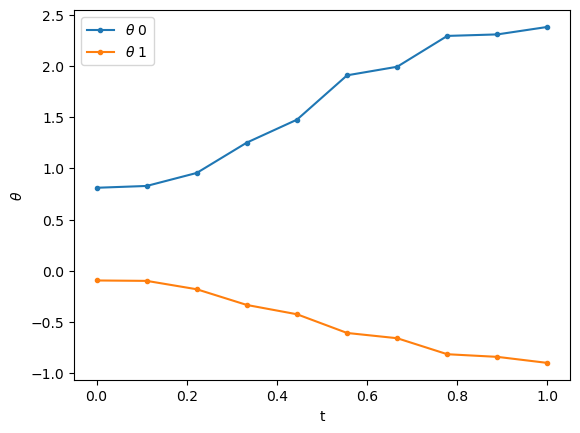

In [54]:
theta_numpy_l = np.array([theta.detach().numpy() for theta in theta_l])

for i in range(pqc.theta_shape):
    plt.plot(t_l, theta_numpy_l[:, i], '.-', label=f'$\\theta$ {i}')
plt.xlabel('t')
plt.ylabel(r'$\theta$')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


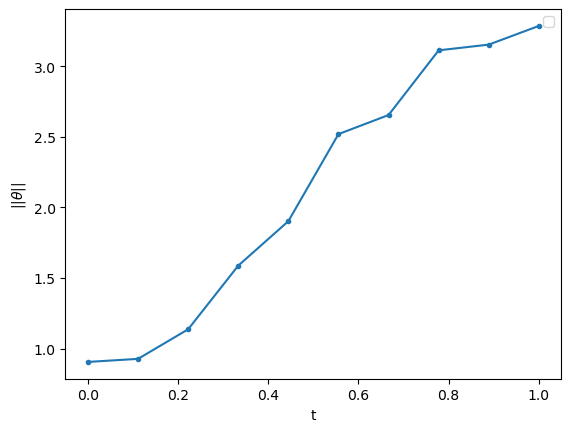

In [55]:
plt.plot(t_l, np.linalg.norm(theta_numpy_l, ord=1, axis=1), '.-')
plt.xlabel('t')
plt.ylabel(r'$||\theta||$')
plt.legend()
plt.show()

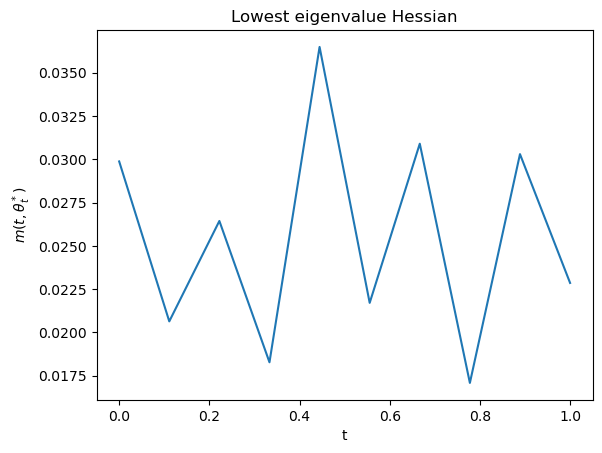

In [56]:
plt.title('Lowest eigenvalue Hessian')
plt.plot(t_l, hess_eig_l)
plt.xlabel('t')
plt.ylabel(r'$m(t, \theta^*_t)$')
plt.show()

We have calculated the berry phase! One can try now other loops (either trivial or topological), larger active spaces, different systems, etc...